In [112]:
import matplotlib as mpl
import pandas as pd
import matplotlib.pylab as plt
import matplotlib.dates as mdates
import numpy as np
from datetime import datetime
import networkx as nx
import netwulf as nw
from itertools import combinations
from collections import defaultdict
import random
from scipy import stats
from networkx.algorithms import community
import community
import json
from tqdm import tqdm  

seed = 1337
random.seed(seed)
np.random.seed(seed)

# Network
This section of the notebook will go through the network analysis of the data. We have used `networkx` to build the networks and `netwulf` to visualise them. The the following sections we will be investigating the full network of all musicians as well as a subset of them based on selected genres. The networks will be studied by calculating different statistics, such as number of nodes, number of links, density, clusterings and more. In addition, we will look at community detection to see how well the different genres manages to partition the networks into communities in comparison to the Louvain algorithm for community detection.

# Load data

In [113]:
song_data = pd.read_pickle('songData.df')
print(f'Number of songs: {len(song_data)}')

Number of songs: 25419


Network visualisation config.

In [114]:
# reading the data from the file
with open('network_figures/config.txt') as f:
    data = f.read()
config = json.loads(data)

## Creating the full network
Calculate all genres associated to each artist as well as how many songs they have made for each genre.

In [115]:
all_artists = set()
artist_genres = dict()
artist_genres_count = defaultdict(lambda: defaultdict(lambda: 0))
for artists, genres in zip(song_data.artists, song_data.genres):
    for artist in artists:
        all_artists = all_artists.union(set([artist]))
        for genre in genres:
            artist_genres_count[artist][genre] += 1
        if artist in artist_genres.keys():
            artist_genres[artist] = artist_genres[artist].union(set(genres))
        else:
            artist_genres[artist] = set(genres)
        

all_artists = list(all_artists)
print(f'Number of unique artists: {len(all_artists)}')

Number of unique artists: 7855


Creating a genre list from which each artist can get their main genre label. In addition, a colour list to colour each node based on their main genre.

In [116]:
genre_list = ['pop', 'rock', 'rap', 'r&b', 'country', 'soul', 
              'singer-songwriter', 'pop-rock', 'trap', 'ballad', 
             'soul pop', 'eighties', 'seventies', 'soundtrack',
             'hip-hop', 'funk', 'dance', 'electronic', 'folk', 'cover', 
             'jazz', 'blues']

In [117]:
colour_list = ['#E74C3C', '#9B59B6', '#3498DB', '#1ABC9C', '#27AE60', '#F4D03F', '#E67E22', '#EDB9B9', '#E7E9B9',
              '#B9EDE0', '#B9D7ED', '#DCB9ED', '#8F2323', '#8F6A23', '#4F8F23', '#23628F', '#6B238F', '#AED6F1',
              '#A3E4D7', '#D4AC0D', '#D7BDE2', '#F5B7B1', '#0A2ADA']

In [118]:
colour_dict = {}
for colour, genre in zip(colour_list, genre_list+['other']):
    colour_dict[genre] = colour

Calculate number of songs each artist has in the data set as well as how many times they have collaborated with other artists.

In [119]:
artist_count = defaultdict(lambda: 0)
artist_colab_count = defaultdict(lambda: defaultdict(lambda: 0))

for artists in song_data.artists:
    for artist in artists:
        artist_count[artist] += 1
        for colab in artists:
            if colab != artist:
                artist_colab_count[artist][colab] += 1

### Add nodes
Add each artist as a node with three attributes
> *genre*: most common genre for that artist within the fixed list 'genre_list'

> *size*: number of times the artist has appeared on Billboard's the hot 100 (used to give each node the correct size)

> *all_genres*: all genres associated with that artist

In [120]:
G = nx.Graph()
for artist in all_artists:
    most_occurences = 0
    max_key = 'other'
    random.shuffle(genre_list)
    
    for genre in genre_list:
        if genre in artist_genres_count[artist]:
            if artist_genres_count[artist][genre] > most_occurences:
                most_occurences = artist_genres_count[artist][genre]
                max_key = genre
                
    G.add_node(artist, 
               genre=max_key, 
               size=artist_count[artist], 
               all_genres=artist_genres[artist], 
               group=colour_dict[max_key])
    
G.number_of_nodes()
print(f'Number of nodes: {G.number_of_nodes()}')

Number of nodes: 7855


### Add edges
Add edges between two artists if they have collaborated on a song and weigh the edge by the number of times they have collaborated.

In [121]:
linked_artists = set()
for artists in song_data.artists:
    if len(artists) > 1:
        for comb in combinations(artists, 2):
            if not comb[0] == comb[1]:
                linked_artists = linked_artists.union({tuple([comb[0], comb[1], artist_colab_count[comb[0]][comb[1]]])})

linked_artists = list(linked_artists)
G.add_weighted_edges_from(linked_artists)
print(f'Number of edges: {G.number_of_edges()}')

Number of edges: 6799


### Helper functions

In [122]:
def randomized_graph(graph, N):
    g = graph.copy()
    swaps = 0
    while swaps < N:
        uv = random.choice(list(g.edges()))
        if uv[0] == uv[1]:
            uv = random.choice(list(g.edges()))
        xy = random.choice(list(g.edges()))
        while uv[1] == xy[0]:
            xy = random.choice(list(g.edges()))
        if not g.has_edge(uv[0], xy[1]) and not g.has_edge(uv[1], xy[0]):
            g.remove_edges_from([uv, xy])
            g.add_edges_from([(uv[0], xy[1]), (uv[1], xy[0])])
            swaps += 1
    return g

In [123]:
def naive_randomized_graph(graph):
    g = nx.MultiGraph(graph)
    edges = list(g.edges())
    sources = [a for a, b in edges]
    targets = [b for a, b in edges]
    unique_list = sources + targets
    random.shuffle(unique_list)
    new_edges = [(unique_list[i], unique_list[i+1]) for i in range(0, len(unique_list)-1, 2)]
    g.remove_edges_from(edges)
    g.add_edges_from(new_edges)
    return g

In [124]:
def get_network_by_genre(G, genre):
    genre_nodes = [node for node, data in G.nodes(data=True) if genre in data['all_genres']]
    return G.subgraph(genre_nodes)

In [125]:
def get_partitioning(filtered_graph):
    partitioning = []
    nc = set(nx.get_node_attributes(filtered_graph, 'group').values())
    for i in nc:
        nodes = (
            node
            for node, data
            in filtered_graph.nodes(data=True)
            if data.get("group") == i
        )
        partitioning.append(filtered_graph.subgraph(nodes))
    return partitioning

In [126]:
def modularity(graph, partitioning):
    M = 0
    L = graph.number_of_edges()
    for subgraph in partitioning:
        Lc = subgraph.number_of_edges()
        kc = sum(graph.degree[node] for node in subgraph.nodes())
        M += Lc/L - (kc / (2 * L))**2
    return M

## Analysis
The full network has now been created and we are ready to do visualisations and analysis. In the following sections we will be working with the full network and sub-networks for the genres: _pop_, _rap_, _rock_, _R&B_, _country_, _funk_, _folk_ and _blues_. For each of the networks we will be investigating the full network as well as versions of the networks where singleton nodes with less than 5 songs are removed. 

# <font color='blue'>Mangler et godt argument her for hvorfor vi har valgt at fjerne singletons med mindre end 5 sange. </font>

### With singletons

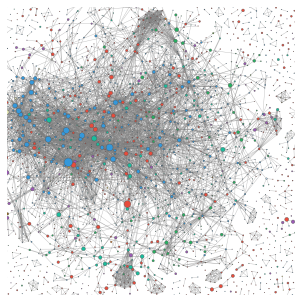

In [127]:
network_G, _ = nw.visualize(G, config=config, plot_in_cell_below=False)
fig, ax = nw.draw_netwulf(network_G)
# plt.savefig("network_figures/G.pdf")

#### Properties
Calculate basic statistics for the network

In [128]:
print(f'Number of Nodes: {G.number_of_nodes()}')
print(f'Number of Links: {G.number_of_edges()}')
print(f'Density: {nx.density(G):.5f}')
print(f'Avg. clustering: {nx.average_clustering(G):.2f}')
degrees = list(dict(G.degree()).values())
print(f'Average degrees: {np.mean(degrees):.2f}')
print(f'Median degrees: {np.median(degrees)}')
print(f'Mode of degrees: {stats.mode(degrees)[0][0]}')
print(f'Minimum degree: {min(degrees)}')
print(f'Maximum degree: {max(degrees)}')

Number of Nodes: 7855
Number of Links: 6799
Density: 0.00022
Avg. clustering: 0.16
Average degrees: 1.73
Median degrees: 0.0
Mode of degrees: 0
Minimum degree: 0
Maximum degree: 108


# <font color='blue'> Kunne godt bruge en kommentar her til statistikkerne</font>

#### Community detection
In this section we will explore the communities of the network. To do this, we are looking at looking at the partition obtained when grouping the artists by their genre. This will be compared to the partition obtained using the Louvain algorithm. To get an indication of whether the two partitions are good at divising the network into modules, both of these partitions will then be juxtapositioned with random networks, based on the real network. When doing this comparison, we can see if the modularity of the two partitions are significantly different than 0.

First off, we will be getting the partitions based on the genres

In [215]:
genre_partitioning = get_partitioning(G)
genre_partitioning_dict = dict()
for partition in genre_partitioning:
    for artist, data in partition.nodes(data=True):
        genre_partitioning_dict[artist] = data['group']

print(f'Genre partitioning modularity using homemade modularity function: {modularity(G, genre_partitioning):.4f}')
print(f'Genre partitioning modularity using python-louvain modularity function: {community.modularity(genre_partitioning_dict, G):.4f}')

Genre partitioning modularity using homemade modularity function: 0.3132
Genre partitioning modularity using python-louvain modularity function: 0.3279


In [216]:
modularity(G, genre_partitioning)

0.31323064713603815

We will now be calculating the modularity of the network based on the partitioning obtained using the Louvain algorithm.

In [130]:
louvain_modularity = community.modularity(community.best_partition(G), G)
print(f'Modularity for the full network: {louvain_modularity:.4f}')

Modularity for the full network: 0.7475


We initially see that the modularity obtained by using the Louvain algorithm is more than twice as large as when using the genres.

##### Building randon network for comparison
Next up, we will be generating a 1000 random networks using the double edge swap algorithm. This makes it so each node in the new random network has the same degree as it had in the original networks, but the connections are different. For each of these random networks, we will be partitioning them using the genres and calculate their modularities.

# <font color='blue'>Måske noget her med hvorfor vi har valgt 1.2*antal edges.</font>

In [136]:
modularity_list = []
N = 1000
graph = G.copy()
for i in tqdm(range(N)):
    RG = nx.double_edge_swap(graph, nswap=graph.number_of_edges()*1.2, max_tries=10000, seed=None)
    new_RG = nw.get_filtered_network(RG, node_group_key='group')
    RG_partitioning = get_partitioning(new_RG)
    modularity_list.append(modularity(RG, RG_partitioning))

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:05<00:00,  5.40it/s]


In [137]:
print(f'Average modularity of random networks: {np.mean(modularity_list):.4f}')
print(f'Standard deviation of modularity of random networks: {np.std(modularity_list):.4f}')

Average modularity of random networks: -0.0012
Standard deviation of modularity of random networks: 0.0048


We see that the mean and standard deviation of the modularity is 0, which is to be expected, as the networks are random, and we therefore shouldn't have any good partition using the genres.

To get an overview of the genre partition and the Louvain algorithm partition, we will now plot the distribution of the configuration model's modularity along side the genre partition's modularity and the Louvain algorithm partition's modularity.

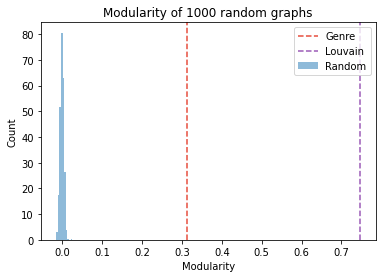

In [153]:
plt.hist(modularity_list, bins=10, alpha=0.5, label='Random', density=True)
plt.axvline(modularity(G, genre_partitioning), color = '#E74C3C', linestyle='--', label='Genre')
plt.axvline(louvain_modularity, color = '#9B59B6', linestyle='--', label='Louvain')
plt.legend()
plt.title(f'Modularity of {N} random graphs')
plt.xlabel('Modularity')
plt.ylabel('Count')
plt.show()

Looking at the figure above, we see that both of the partitioning methods leads to a modularity significantly different from 0, and thereby also larger than any of those from the random networks. Though, as touched upon previously, the modularity of the networks partitioned using the Louvain algorithm is more than twice the size of genre partition. To get an understanding of how this partition looks, we will be visualising the graph with the Louvain partitioning.

In [175]:
G_louvain_partition = community.best_partition(G)
G_louvain = G.copy()
for artist, data in G_louvain.nodes(data=True):
    data['group'] = G_louvain_partition[artist]

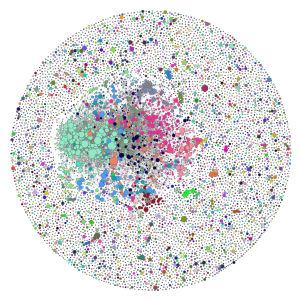

In [180]:
network_G_louvain, _ = nw.visualize(G_louvain, config=config, plot_in_cell_below=False)
fig, ax = nw.draw_netwulf(network_G_louvain)

Noticeable here is that the Louvain algorithm actually also groups many of the rap, pop, rock and country artists together into four separate groups, though in general also a lot more groups are seen. Let's see just how many groups:

In [202]:
print(f'Number of groups using genres: {len(set(data["group"] for art, data in G.nodes(data=True)))}')
print(f'Number of groups using Louvain: {max(G_louvain_partition.values())+1}')

Number of groups using genres: 23
Number of groups using Louvain: 4991


We here see that the Louvain algorithm partitions the network into an immense 4991 groups, which is enormous compared to the 7855 nodes in the graph. An explanation for this is that the large number of singleton nodes are probably given their own group, which gives a good partitioning, but doesn't make much sense compared to a partitioning using genres.

### Without singletons
This then brings us on to the next analysis for the full network; the version where we will be removing singleton nodes with less than 5 songs. The following section will go through the same steps as for the complete network, so not everything will be described with the same level of detail.
# <font color='blue'>Er den sidste sætning her en ok kommentar?</font>

In [203]:
G_no_singles = G.copy()
for artist, data in G.nodes(data=True):
    if G_no_singles.degree(artist) == 0 and data['size'] < 5:
        G_no_singles.remove_node(artist)

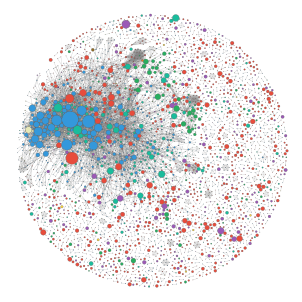

In [204]:
network_G_no_singles, _ = nw.visualize(G_no_singles, config=config, plot_in_cell_below=False)
fig, ax = nw.draw_netwulf(network_G_no_singles)
# plt.savefig("network_figures/G_no_singles.pdf")

#### Properties
Calculate basic statistics for the network

In [206]:
graph = G_no_singles
print(f'Number of Nodes: {graph.number_of_nodes()}')
print(f'Number of Links: {graph.number_of_edges()}')
print(f'Density: {nx.density(graph):.5f}')
print(f'Avg. clustering: {nx.average_clustering(graph):.2f}')
degrees = list(dict(graph.degree()).values())
print(f'Average degrees: {np.mean(degrees):.2f}')
print(f'Median degrees: {np.median(degrees)}')
print(f'Mode of degrees: {stats.mode(degrees)[0][0]}')
print(f'Minimum degree: {min(degrees)}')
print(f'Maximum degree: {max(degrees)}')

Number of Nodes: 4154
Number of Links: 6799
Density: 0.00079
Avg. clustering: 0.30
Average degrees: 3.27
Median degrees: 1.0
Mode of degrees: 1
Minimum degree: 0
Maximum degree: 108


Compared to the full network, we have now gone down from 7850 to 4154 nodes while keeping the same number of edges. As expected, all the other network properties have gone up, meaning that with a larger density, avg. clustering and average degrees, we should now see a network that is more connected.

#### Community detection
We will again communities of the network using both the genres and the Louvain algorithm, both of which will be compared to random networks.

First off, we will be getting the partitions based on the genres.

In [211]:
genre_partitioning = get_partitioning(G_no_singles)
genre_partitioning_dict = dict()
for partition in genre_partitioning:
    for artist, data in partition.nodes(data=True):
        genre_partitioning_dict[artist] = data['group']

print(f'Genre partitioning modularity using homemade modularity function: {modularity(G_no_singles, genre_partitioning):.4f}')
print(f'Genre partitioning modularity using python-louvain modularity function: {community.modularity(genre_partitioning_dict, G_no_singles):.4f}')

Genre partitioning modularity using homemade modularity function: 0.3132
Genre partitioning modularity using python-louvain modularity function: 0.3279


In [213]:
len(genre_partitioning)

22

In [214]:
modularity(G_no_singles, genre_partitioning)

0.31323064713603815

In [218]:
len(G_no_singles.nodes(data=True))

4154

We will now be calculating the modularity of the network based on the partitioning obtained using the Louvain algorithm.

In [130]:
louvain_modularity = community.modularity(community.best_partition(G), G)
print(f'Modularity for the full network: {louvain_modularity:.4f}')

Modularity for the full network: 0.7475


We initially see that the modularity obtained by using the Louvain algorithm is more than twice as large as when using the genres.

##### Building randon network for comparison
Next up, we will be generating a 1000 random networks using the double edge swap algorithm. This makes it so each node in the new random network has the same degree as it had in the original networks, but the connections are different. For each of these random networks, we will be partitioning them using the genres and calculate their modularities.

# Måske noget her med hvorfor vi har valgt 1.2*antal edges.


In [136]:
modularity_list = []
N = 1000
graph = G.copy()
for i in tqdm(range(N)):
    RG = nx.double_edge_swap(graph, nswap=graph.number_of_edges()*1.2, max_tries=10000, seed=None)
    new_RG = nw.get_filtered_network(RG, node_group_key='group')
    RG_partitioning = get_partitioning(new_RG)
    modularity_list.append(modularity(RG, RG_partitioning))

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:05<00:00,  5.40it/s]


In [137]:
print(f'Average modularity of random networks: {np.mean(modularity_list):.4f}')
print(f'Standard deviation of modularity of random networks: {np.std(modularity_list):.4f}')

Average modularity of random networks: -0.0012
Standard deviation of modularity of random networks: 0.0048


We see that the mean and standard deviation of the modularity is 0, which is to be expected, as the networks are random, and we therefore shouldn't have any good partition using the genres.

To get an overview of the genre partition and the Louvain algorithm partition, we will now plot the distribution of the configuration model's modularity along side the genre partition's modularity and the Louvain algorithm partition's modularity.

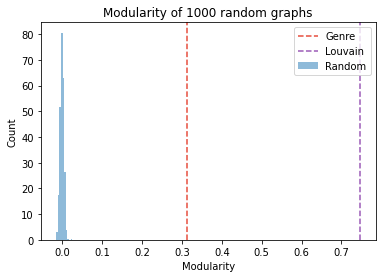

In [153]:
plt.hist(modularity_list, bins=10, alpha=0.5, label='Random', density=True)
plt.axvline(modularity(G, genre_partitioning), color = '#E74C3C', linestyle='--', label='Genre')
plt.axvline(louvain_modularity, color = '#9B59B6', linestyle='--', label='Louvain')
plt.legend()
plt.title(f'Modularity of {N} random graphs')
plt.xlabel('Modularity')
plt.ylabel('Count')
plt.show()

Looking at the figure above, we see that both of the partitioning methods leads to a modularity significantly different from 0, and thereby also larger than any of those from the random networks. Though, as touched upon previously, the modularity of the networks partitioned using the Louvain algorithm is more than twice the size of genre partition. To get an understanding of how this partition looks, we will be visualising the graph with the Louvain partitioning.

In [175]:
G_louvain_partition = community.best_partition(G)
G_louvain = G.copy()
for artist, data in G_louvain.nodes(data=True):
    data['group'] = G_louvain_partition[artist]

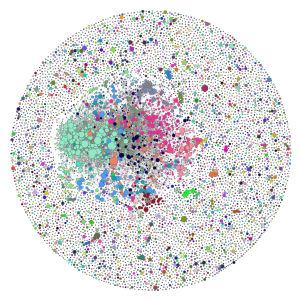

In [180]:
network_G_louvain, _ = nw.visualize(G_louvain, config=config, plot_in_cell_below=False)
fig, ax = nw.draw_netwulf(network_G_louvain)

Noticeable here is that the Louvain algorithm actually also groups many of the rap, pop, rock and country artists together into four separate groups, though in general also a lot more groups are seen. Let's see just how many groups:

In [202]:
print(f'Number of groups using genres: {len(set(data["group"] for art, data in G.nodes(data=True)))}')
print(f'Number of groups using Louvain: {max(G_louvain_partition.values())+1}')

Number of groups using genres: 23
Number of groups using Louvain: 4991


We here see that the Louvain algorithm partitions the network into an immense 4991 groups, which is enormous compared to the 7855 nodes in the graph. An explanation for this is that the large number of singleton nodes are probably given their own group, which gives a good partitioning, but doesn't make much sense compared to a partitioning using genres.

4991